# Kalman Filter Class Development

In [1]:
from __future__ import annotations

from abc import ABC, abstractmethod
from typing import Optional, Protocol

import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt

# 1 - SystemModel

`SystemModel` defines the minimal, filter-agnostic interface that all Kalman filters
operate against. It formalizes *what* information a filter may request from a model,
without embedding any system physics or runtime logic.

At a minimum, every model must provide:
- `Q(dt)`: process noise covariance (n × n)
- `R()`: measurement noise covariance (m × m)

These two methods form the core contract required by all Kalman-type filters.

Additional methods are required depending on the filter variant:
- **LinearKF** requires `F(dt)` (state transition) and `H()` (measurement matrix)
- **EKF** requires nonlinear dynamics `f`, measurement model `h`,
  and their Jacobians
- **UKF** requires `f` and `h`, with sigma-point handling managed by the filter

A model only needs to implement the subset of methods required by the filter in use.

`SystemModel` itself contains no runtime behavior. It exists solely to enforce a
well-defined structural contract between estimation algorithms and system dynamics.
This separation keeps filters mathematically focused, enables interchangeable models,
and allows new system representations to be introduced without modifying filter code.

In [2]:
class SystemModel(Protocol):
    """
    Base protocol defining the interface between system models and
    Kalman-family estimation algorithms.

    A SystemModel describes the stochastic properties of a system.
    It contains no estimation logic and makes no assumptions about
    which Kalman filter variant will be used.

    Universal contract (required for all Kalman filters)
    ----------------------------------------------------
    Q(dt): process noise covariance matrix (n × n)
    R():   measurement noise covariance matrix (m × m)

    These two methods are the only requirements common to all
    linear, nonlinear, and sigma-point Kalman filters.

    Additional methods may be required depending on the filter:
      - LinearKF:     F(dt), H(), (optional G(dt))
      - ExtendedKF:   f(x,u,dt), h(x), F_jacobian(...), H_jacobian(...)
      - UnscentedKF:  f(x,u,dt), h(x)

    Filters are responsible for declaring and validating their own
    model requirements.
    """
    def Q(self, dt: float) -> NDArray[np.float64]:
        ...

    def R(self) -> NDArray[np.float64]:
        ...

In [3]:
class LinearGaussianModel:
    """
    Concrete SystemModel implementation for linear-Gaussian systems with
    constant matrices F, H, Q, R (and optional G).

        x_{k+1} = F x_k + G u_k + w_k
        z_k     = H x_k + v_k

    F, H, Q, R are constant; dt is ignored in this simple model.
    """

    def __init__(self, F, H, Q, R, G=None) -> None:
        self.F_mat = np.asarray(F, dtype=float)
        self.H_mat = np.asarray(H, dtype=float)
        self.Q_mat = np.asarray(Q, dtype=float)
        self.R_mat = np.asarray(R, dtype=float)
        self.G_mat = None if G is None else np.asarray(G, dtype=float)

        n = self.F_mat.shape[0]
        
        if self.F_mat.shape != (n, n):
            raise ValueError("F must be square (n x n).")
        
        if self.Q_mat.shape != (n, n):
            raise ValueError("Q must be square (n x n).")
        
        if self.H_mat.shape[1] != n:
            raise ValueError("H must have n columns matching F.")
        
        m = self.H_mat.shape[0]
        
        if self.R_mat.shape != (m, m):
            raise ValueError("R must be square (m x m).")
        
        if self.G_mat is not None and self.G_mat.shape[0] != n:
            raise ValueError("G must have same row count as F.")

    # ---- SystemModel interface (linear part) ----

    def F(self, dt: float) -> NDArray[np.float64]:
        return self.F_mat

    def H(self) -> NDArray[np.float64]:
        return self.H_mat

    def Q(self, dt: float) -> NDArray[np.float64]:
        return self.Q_mat

    def R(self) -> NDArray[np.float64]:
        return self.R_mat

    def G(self, dt: float) -> NDArray[np.float64]:
        if self.G_mat is None:
            raise AttributeError("This model does not define a control matrix G.")
        return self.G_mat

In [4]:
class NonlinearGaussianModel:
    """
    Nonlinear-Gaussian state-space model.

    Defines a nonlinear system under Gaussian uncertainty:

        x_{k+1} = f(x_k, u_k, dt) + w_k
        z_k     = h(x_k)          + v_k

    where:
        w_k ~ N(0, Q(dt))
        v_k ~ N(0, R())

    This class validates and exposes a user-defined nonlinear system model.
    It contains no estimation logic and is compatible with EKF, UKF, and
    other nonlinear Gaussian estimators.

    Jacobian methods (*_jacobian) are required only by EKF-type filters.
    """

    def __init__(self, model) -> None:
        self.model = model

        # ---- Required nonlinear mappings ----
        for name in ("f", "h", "Q", "R"):
            if not hasattr(model, name) or not callable(getattr(model, name)):
                raise TypeError(
                    f"NonlinearGaussianModel requires callable '{name}(...)'."
                )

        # ---- Basic noise sanity checks ----
        Q0 = np.asarray(model.Q(0.0), dtype=float)
        R0 = np.asarray(model.R(), dtype=float)

        if Q0.ndim != 2 or Q0.shape[0] != Q0.shape[1]:
            raise ValueError("Q(dt) must return a square matrix.")

        if R0.ndim != 2 or R0.shape[0] != R0.shape[1]:
            raise ValueError("R() must return a square matrix.")

        self.n = Q0.shape[0]
        self.m = R0.shape[0]

    # ------------------------------------------------------------------
    # Nonlinear system interface
    # ------------------------------------------------------------------

    def f(
        self,
        x: NDArray[np.float64],
        u=None,
        dt: float = 0.0,
    ) -> NDArray[np.float64]:
        return self.model.f(x, u, dt)

    def h(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        return self.model.h(x)

    # ------------------------------------------------------------------
    # Noise models
    # ------------------------------------------------------------------

    def Q(self, dt: float) -> NDArray[np.float64]:
        return self.model.Q(dt)

    def R(self) -> NDArray[np.float64]:
        return self.model.R()

    # ------------------------------------------------------------------
    # Jacobians (EKF only)
    # ------------------------------------------------------------------

    def F_jacobian(
        self,
        x: NDArray[np.float64],
        u=None,
        dt: float = 0.0,
    ) -> NDArray[np.float64]:
        if not hasattr(self.model, "F_jacobian"):
            raise AttributeError(
                "EKF requires model.F_jacobian(x, u, dt), but it is not defined."
            )
        return self.model.F_jacobian(x, u, dt)

    def H_jacobian(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        if not hasattr(self.model, "H_jacobian"):
            raise AttributeError(
                "EKF requires model.H_jacobian(x), but it is not defined."
            )
        return self.model.H_jacobian(x)


# 2 - BaseKalmanFilter

This base class defines the reusable structure shared by all Kalman filter
variants. It does not contain any filtering equations. The goal is to avoid
rewriting the same state storage, input validation, and predict/update calling
logic across LinearKF, EKF, and UKF.

The separation of responsibilities is intentional:

- The **SystemModel** defines the system’s behaviour: the state dynamics,
  the measurement relationship, and the noise covariances (Q and R).
  Different physical systems (e.g., spacecraft, vehicles, sensors) implement
  their own SystemModel.

- **BaseKalmanFilter** provides the common scaffold: it stores the state `x`
  and covariance `P`, exposes unified methods (`predict`, `update`, `step`),
  and enforces that subclasses supply the actual filtering mathematics.

- Each concrete filter (**LinearKF**, **EKF**, **UKF**) implements its own math
  inside `_predict_impl` and `_update_impl`, using the functions supplied by
  the model (e.g., F/H for linear systems or f/h for nonlinear systems).

As a result, the Kalman filter logic is cleanly separated from the system
dynamics. Any well-formed SystemModel can be paired with any Kalman filter
variant without modifying the filter code.


In [5]:
class BaseKalmanFilter(ABC):
    """
    Abstract base class for Kalman-family state estimators.

    This class provides all shared infrastructure required by linear,
    extended, unscented, and related Kalman filters.

    Design principles
    -----------------
    - Concrete filter classes contain only algorithm-specific math:
        * __init__
        * _predict_impl
        * _update_impl
    - All model validation, lifecycle control, diagnostics, and state
      bookkeeping are centralized here.
    - Model validation is performed exactly once during construction and
      is dispatched automatically based on the concrete filter class.
    - No dynamic schemas, reflection tricks, or user-supplied flags.

    Responsibilities
    ----------------
    - Parse and validate initial state definitions
    - Construct and validate initial covariance
    - Maintain state and covariance storage
    - Manage optional named-state indexing
    - Store diagnostics from the most recent predict/update cycle
    - Validate SystemModel compatibility and dimensional consistency

    Non-responsibilities
    --------------------
    - No system dynamics or measurement logic
    - No assumptions about linearity or nonlinearity
    - No enforcement of time-step semantics (`dt` is filter-specific)
    - No algorithm-specific estimation math

    Subclass contract
    -----------------
    Concrete filters must:
    - Call this constructor
    - Implement _predict_impl(u, dt)
    - Implement _update_impl(z)

    All public methods mutate internal state and return None.

    This design is intentionally compatible with static languages
    (e.g. C++) and avoids reliance on dynamic Python features.
    """

    # ============================================================
    # Construction
    # ============================================================
    def __init__(self, states, initial_covariance, model) -> None:
        # --------------------------------------------------
        # 0) Minimal universal model sanity check
        # --------------------------------------------------
        for name in ("Q", "R"):
            if not callable(getattr(model, name, None)):
                raise TypeError(f"SystemModel must define callable '{name}()'.")

        self.model = model

        # --------------------------------------------------
        # 1) Build initial state
        # --------------------------------------------------
        if isinstance(states, dict):
            self._state_names = list(states.keys())
            self._state_index = {name: i for i, name in enumerate(self._state_names)}
            x0 = np.array([states[name] for name in self._state_names], dtype=float)
        else:
            self._state_names = None
            self._state_index = None
            x0 = np.atleast_1d(np.asarray(states, dtype=float))

        if x0.ndim != 1:
            raise ValueError("Initial state must be a 1D vector.")

        self.n = x0.size

        # --------------------------------------------------
        # 2) Build initial covariance
        # --------------------------------------------------
        if isinstance(initial_covariance, dict):
            if self._state_names is None:
                raise ValueError("Dict covariance requires named-state initialization.")

            P0 = np.zeros((self.n, self.n), dtype=float)
            for i, name in enumerate(self._state_names):
                if name not in initial_covariance:
                    raise ValueError(f"Missing covariance entry for state '{name}'.")
                P0[i, i] = float(initial_covariance[name])

        else:
            P0_arr = np.asarray(initial_covariance, dtype=float)

            if P0_arr.ndim == 0:
                P0 = np.eye(self.n) * float(P0_arr)

            elif P0_arr.ndim == 1:
                if P0_arr.size != self.n:
                    raise ValueError(
                        f"1D covariance must have length {self.n}, got {P0_arr.size}."
                    )
                P0 = np.diag(P0_arr)

            elif P0_arr.ndim == 2:
                if P0_arr.shape != (self.n, self.n):
                    raise ValueError(
                        f"2D covariance must be ({self.n},{self.n}), got {P0_arr.shape}."
                    )
                P0 = P0_arr

            else:
                raise ValueError(
                    "initial_covariance must be scalar, 1D, 2D, or dict{name -> var}."
                )

        # --------------------------------------------------
        # 3) Final storage
        # --------------------------------------------------
        self.x = x0.copy()
        self.P = np.atleast_2d(P0).copy()

        # --------------------------------------------------
        # 4) Diagnostics storage
        # --------------------------------------------------
        self._last_x_pred: Optional[NDArray[np.float64]] = None
        self._last_P_pred: Optional[NDArray[np.float64]] = None
        self._last_z_pred: Optional[NDArray[np.float64]] = None
        self._last_innovation: Optional[NDArray[np.float64]] = None
        self._last_S: Optional[NDArray[np.float64]] = None
        self._last_gain: Optional[NDArray[np.float64]] = None

        # --------------------------------------------------
        # 5) One-time filter-specific model validation
        # --------------------------------------------------
        self._validate_model()

    # ============================================================
    # Model validation (centralized, class-dispatched)
    # ============================================================
    def _validate_model(self) -> None:
        cls_name = type(self).__name__

        if cls_name == "LinearKF":
            self._validate_lkf_model()

        elif cls_name == "ExtendedKF":
            self._validate_ekf_model()

        elif cls_name == "UnscentedKF":
            self._validate_ukf_model()

        else:
            raise NotImplementedError(f"No model validation rules defined for filter '{cls_name}'.")

    def _validate_lkf_model(self) -> None:
        dt = 0.0

        for name in ("F", "H", "Q", "R"):
            if not callable(getattr(self.model, name, None)):
                raise TypeError(f"LinearKF requires model method '{name}()'.")

        F = np.asarray(self.model.F(dt))
        Q = np.asarray(self.model.Q(dt))
        H = np.asarray(self.model.H())
        R = np.asarray(self.model.R())

        if F.shape != (self.n, self.n):
            raise ValueError("F(dt) must have shape (n, n).")

        if Q.shape != (self.n, self.n):
            raise ValueError("Q(dt) must have shape (n, n).")

        if H.ndim != 2 or H.shape[1] != self.n:
            raise ValueError("H() must have shape (m, n).")

        self.m = H.shape[0]

        if R.shape != (self.m, self.m):
            raise ValueError("R() must have shape (m, m).")

    def _validate_ekf_model(self) -> None:
        dt = 0.0
        x = self.x.copy()

        for name in ("f", "h", "F_jacobian", "H_jacobian", "Q", "R"):
            if not callable(getattr(self.model, name, None)):
                raise TypeError(f"ExtendedKF requires model method '{name}()'.")

        x_next = np.asarray(self.model.f(x, u=None, dt=dt))
        if x_next.shape != (self.n,):
            raise ValueError("f(x,u,dt) must return shape (n,).")

        F = np.asarray(self.model.F_jacobian(x, u=None, dt=dt))
        if F.shape != (self.n, self.n):
            raise ValueError("F_jacobian(x,u,dt) must have shape (n, n).")

        Q = np.asarray(self.model.Q(dt))
        if Q.shape != (self.n, self.n):
            raise ValueError("Q(dt) must have shape (n, n).")

        z = np.asarray(self.model.h(x))
        if z.ndim != 1:
            raise ValueError("h(x) must return a 1D measurement vector.")

        self.m = z.size

        H = np.asarray(self.model.H_jacobian(x))
        if H.shape != (self.m, self.n):
            raise ValueError("H_jacobian(x) must have shape (m, n).")

        R = np.asarray(self.model.R())
        if R.shape != (self.m, self.m):
            raise ValueError("R() must have shape (m, m).")

    def _validate_ukf_model(self) -> None:
        raise NotImplementedError("UnscentedKF validation not implemented yet.")

    # ============================================================
    # Numerical utilities
    # ============================================================
    @staticmethod
    def _symmetrize(P: NDArray[np.float64]) -> NDArray[np.float64]:
        return 0.5 * (P + P.T)

    # ============================================================
    # External interface
    # ============================================================
    def predict(self, u=None, dt=None) -> None:
        self._predict_impl(u=u, dt=dt)

    def update(self, z) -> None:
        z = np.atleast_1d(np.asarray(z, dtype=float))
        self._update_impl(z=z)

    def step(self, z, u=None, dt=None) -> None:
        self.predict(u=u, dt=dt)
        self.update(z=z)

    # ============================================================
    # State accessors
    # ============================================================
    @property
    def state(self) -> NDArray[np.float64]:
        return self.x.copy()

    @property
    def covariance(self) -> NDArray[np.float64]:
        return self.P.copy()

    # ============================================================
    # Diagnostics accessors
    # ============================================================
    @property
    def last_predicted_state(self):
        return None if self._last_x_pred is None else self._last_x_pred.copy()

    @property
    def last_predicted_covariance(self):
        return None if self._last_P_pred is None else self._last_P_pred.copy()

    @property
    def last_z_pred(self):
        return None if self._last_z_pred is None else self._last_z_pred.copy()

    @property
    def last_innovation(self):
        return None if self._last_innovation is None else self._last_innovation.copy()

    @property
    def last_S(self):
        return None if self._last_S is None else self._last_S.copy()

    @property
    def last_gain(self):
        return None if self._last_gain is None else self._last_gain.copy()

    # ============================================================
    # Named-state access
    # ============================================================
    def get_estimate_of(self, name: str) -> float:
        if self._state_index is None:
            raise AttributeError("Named state access not available.")
        return float(self.x[self._state_index[name]])

    def get_prediction_of(self, name: str) -> float:
        if self._state_index is None:
            raise AttributeError("Named state access not available.")
        if self._last_x_pred is None:
            raise RuntimeError("No prediction stored yet.")
        return float(self._last_x_pred[self._state_index[name]])

    # ============================================================
    # Subclass-required methods
    # ============================================================
    @abstractmethod
    def _predict_impl(self, u, dt) -> None:
        pass

    @abstractmethod
    def _update_impl(self, z) -> None:
        pass


# 3 - KalmanLogger

In [6]:
class KalmanLogger:
    """
    Generic logger for Kalman filter executions.

    This class records numerical quantities produced during the
    predict/update cycle of a BaseKalmanFilter without imposing any
    assumptions about:
      - state dimension
      - linearity
      - filter variant (KF / EKF / UKF)
      - presentation or formatting

    Logged quantities correspond to standard Kalman notation:

      x_pred[n]  -> x_{n|n-1}   (prior mean)
      P_pred[n]  -> P_{n|n-1}   (prior covariance)
      z_pred[n]  -> z_{n|n-1}   (predicted measurement)
      x_est[n]   -> x_{n|n}     (posterior mean)
      P_est[n]   -> P_{n|n}     (posterior covariance)
      K[n]       -> K_n         (Kalman gain)
      innov[n]   -> y_n         (innovation)
      S[n]       -> S_n         (innovation covariance)
      NIS[n]     -> y_nᵀ S_n⁻¹ y_n  (Normalized Innovation Squared)

    The logger is intentionally presentation-agnostic. Tabular views,
    spreadsheet export, and plotting utilities are provided as optional
    convenience methods layered on top of the raw numerical logs.
    """

    def __init__(self) -> None:
        # --- Meta ---
        self.n = []          # step index
        self.t = []          # timestamps
        self.z = []          # measurements
        self.z_pred = []     # predicted measurements

        # --- State & covariance ---
        self.x_pred = []     # x_{n|n-1}
        self.P_pred = []     # P_{n|n-1}
        self.x_est = []      # x_{n|n}
        self.P_est = []      # P_{n|n}

        # --- Diagnostics ---
        self.K = []          # Kalman gain
        self.innov = []      # innovation y_n
        self.S = []          # innovation covariance
        self.NIS = []        # normalized innovation squared

    # ------------------------------------------------------------------
    # Logging after update
    # ------------------------------------------------------------------
    def log(
        self,
        kf: "BaseKalmanFilter",
        n: int | None = None,
        t: float | None = None,
        z=None,
    ) -> None:
        """
        Log filter quantities AFTER update() has been called.

        The prediction quantities stored correspond to the prior used
        for the update at the same index n.
        """
        self.n.append(n)
        self.t.append(t)
        self.z.append(np.nan if z is None else np.asarray(z, dtype=float).copy())

        # --- Prediction ---
        x_pred = kf.last_predicted_state
        P_pred = kf.last_predicted_covariance
        z_pred = kf.last_z_pred

        self.x_pred.append(np.nan if x_pred is None else x_pred.copy())
        self.P_pred.append(np.nan if P_pred is None else P_pred.copy())
        self.z_pred.append(np.nan if z_pred is None else z_pred.copy())

        # --- Posterior ---
        self.x_est.append(kf.state.copy())
        self.P_est.append(kf.covariance.copy())

        # --- Diagnostics ---
        K = kf.last_gain
        y = kf.last_innovation
        S = kf.last_S

        self.K.append(np.nan if K is None else K.copy())
        self.innov.append(np.nan if y is None else y.copy())
        self.S.append(np.nan if S is None else S.copy())

        # --- NIS ---
        if y is not None and S is not None:
            try:
                nis = float(y.T @ np.linalg.solve(S, y))
            except np.linalg.LinAlgError:
                nis = np.nan
        else:
            nis = np.nan

        self.NIS.append(nis)

    # ------------------------------------------------------------------
    # Structured access
    # ------------------------------------------------------------------
    def step(self, idx: int) -> dict:
        """
        Return all logged quantities for a single step as a structured dict.
        """
        return {
            "n": self.n[idx],
            "t": self.t[idx],
            "z": self.z[idx],
            "z_pred": self.z_pred[idx],

            "x_pred": self.x_pred[idx],
            "P_pred": self.P_pred[idx],

            "x_est": self.x_est[idx],
            "P_est": self.P_est[idx],

            "K": self.K[idx],
            "innovation": self.innov[idx],
            "S": self.S[idx],
            "NIS": self.NIS[idx],
        }

    # ------------------------------------------------------------------
    # Batch export
    # ------------------------------------------------------------------
    def as_arrays(self) -> dict:
        """
        Export all logged quantities as numpy arrays.
        """
        out = {}

        out["n"] = np.array(self.n, dtype=object)
        out["t"] = np.array(self.t, dtype=object)
        out["z"] = np.array(self.z, dtype=object)
        out["z_pred"] = np.array(self.z_pred, dtype=object)

        out["x_pred"] = np.array(self.x_pred, dtype=object)
        out["P_pred"] = np.array(self.P_pred, dtype=object)

        if self.x_est:
            out["x_est"] = np.stack(self.x_est).astype(float)
            out["P_est"] = np.stack(self.P_est).astype(float)
        else:
            out["x_est"] = np.empty((0, 0))
            out["P_est"] = np.empty((0, 0, 0))

        out["K"] = np.array(self.K, dtype=object)
        out["innovation"] = np.array(self.innov, dtype=object)
        out["S"] = np.array(self.S, dtype=object)
        out["NIS"] = np.array(self.NIS, dtype=object)

        return out

    # ------------------------------------------------------------------
    # Tabular export
    # ------------------------------------------------------------------
    def to_dataframe(self):
        """
        Convert logged data into a pandas DataFrame.

        Each row corresponds to a filter step n.
        Vector- and matrix-valued quantities are stored as objects.
        """
        try:
            import pandas as pd
        except ImportError as e:
            raise ImportError("pandas is required for to_dataframe().") from e

        rows = []
        for i in range(len(self.n)):
            rows.append({
                # --- Indexing ---
                "n": self.n[i],
                "t": self.t[i],

                # --- Measurements ---
                "z": self.z[i],
                "z_pred": self.z_pred[i],

                # --- Innovation space ---
                "innovation": self.innov[i],
                "S": self.S[i],
                "K": self.K[i],

                # --- State space ---
                "x_pred": self.x_pred[i],
                "x_est": self.x_est[i],

                # --- Covariance space ---
                "P_pred": self.P_pred[i],
                "P_est": self.P_est[i],

                # --- Consistency metric ---
                "NIS": self.NIS[i],
            })

        return pd.DataFrame(rows)

    def to_csv(self, path: str, **kwargs) -> None:
        """
        Export logged data to a CSV file.
        """
        self.to_dataframe().to_csv(path, index=False, **kwargs)

    def to_excel(self, path: str, **kwargs) -> None:
        """
        Export logged data to an Excel file.
        """
        self.to_dataframe().to_excel(path, index=False, **kwargs)


# 4 - Linear Kalman Filter

## 4.1 - LinearKF

In [7]:
class LinearKF(BaseKalmanFilter):
    """
    Discrete-time Linear Kalman Filter for (optionally) time-varying
    linear-Gaussian systems.

    System model
    ------------
        x_{n+1} = F(dt) x_n + G(dt) u_n + w_n
        z_n     = H()   x_n             + v_n

    Noise assumptions
    -----------------
        w_n ~ N(0, Q(dt))   process noise
        v_n ~ N(0, R())     measurement noise

    Estimation semantics
    --------------------
    - predict():
        Computes the a priori (prior) estimate:
            x_{n+1|n}, P_{n+1|n}

    - update(z):
        Computes the a posteriori (posterior) estimate:
            x_{n|n}, P_{n|n}

    Model contract
    --------------
    Required:
      - F(dt): (n x n) state transition matrix
      - H():   (m x n) measurement matrix
      - Q(dt): (n x n) process noise covariance
      - R():   (m x m) measurement noise covariance

    Optional (only if control input u is provided):
      - G(dt): (n x r) control-input matrix

    Numerical stability notes
    -------------------------
    - Kalman gain is computed via linear solve (no explicit inverse).
    - Joseph form covariance update is used to preserve symmetry and
      positive semi-definiteness.
    - Covariance matrices are explicitly symmetrized to reduce
      floating-point drift.
    """

    def __init__(self, states, initial_covariance, model: "SystemModel") -> None:
        
        super().__init__(states=states, initial_covariance=initial_covariance, model=model)


    # ------------------------------------------------------------------
    # Prediction implmentation (time update)
    # ------------------------------------------------------------------
    def _predict_impl(self, u, dt) -> None:
        """
        Time update (prediction).

        Computes the a priori estimate:
            
            x_{n+1|n} = F x_n + G u_n
            
            P_{n+1|n} = F P_n F^T + Q
        """
        # Clear update diagnostics
        self._last_z_pred = None
        self._last_innovation = None
        self._last_S = None
        self._last_gain = None


        if dt is None:
            raise ValueError("LinearKF.predict() requires a time step dt.")

        # Retrieve model components
        F = np.asarray(self.model.F(dt), dtype=float)
        Q = np.asarray(self.model.Q(dt), dtype=float)

        # --- State prediction ---
        x_pred = F @ self.x

        # Optional control input
        if u is not None:
            if not hasattr(self.model, "G"):
                raise AttributeError("Control input u was provided, but model does not define G(dt).")
            G = np.asarray(self.model.G(dt), dtype=float)
            u = np.atleast_1d(np.asarray(u, dtype=float))
            x_pred = x_pred + G @ u

        # --- Covariance prediction ---
        P_pred = F @ self.P @ F.T + Q
        P_pred = self._symmetrize(P_pred)

        # Store diagnostics (a priori)
        self._last_x_pred = x_pred.copy()
        self._last_P_pred = P_pred.copy()

        # Commit
        self.x = x_pred
        self.P = P_pred

    # ------------------------------------------------------------------
    # Update implementation (measurement correction)
    # ------------------------------------------------------------------
    def _update_impl(self, z) -> None:
        """
        Measurement update (correction).

        Computes the a posteriori estimate:

            innovation        y_n = z_n - H x_{n|n-1}
            
            innovation_cov    S_k = H P_{n|n-1} H^T + R
            
            kalman_gain       K_k = P_{n|n-1} H^T S_n^{-1}

            x_{n|n} = x_{n|n-1} + K_n y_n
            P_{n|n} = (I - K_n H) P_{n|n-1} (I - K_n H)^T + K_n R K_n^T
        """
        H = np.asarray(self.model.H(), dtype=float)
        R = np.asarray(self.model.R(), dtype=float)

        z = np.atleast_1d(np.asarray(z, dtype=float))
        if z.shape[0] != H.shape[0]:
            raise ValueError(f"Measurement dimension mismatch: expected ({H.shape[0]},), got {z.shape}.")

        # Predicted measurment
        z_pred = H @ self.x
        
        # --- Innovation (residual), y_k ---
        y = z - z_pred

        # --- Innovation covariance, S_k ---
        S = H @ self.P @ H.T + R
        S = self._symmetrize(S)

        # --- Kalman gain, K_k = P H^T S^{-1} ---
        try:
            K = np.linalg.solve(S, (self.P @ H.T).T).T
        except np.linalg.LinAlgError as e:
            raise np.linalg.LinAlgError("Innovation covariance is singular or ill-conditioned.") from e

        # --- State update, x_{k|k} = x_{k|k-1} + K_k y_k ---
        x_upd = self.x + K @ y

        # --- Covariance update (Joseph form), P_{k|k} = (I - K_k H) P_{k|k-1} (I - K_k H)^T + K_k R K_k^T ---
        I = np.eye(self.n)
        I_minus_KH = I - K @ H

        P_upd = (I_minus_KH @ self.P @ I_minus_KH.T) + (K @ R @ K.T)
        P_upd = self._symmetrize(P_upd)

        # Commit
        self.x = x_upd
        self.P = P_upd

        # Diagnostics
        self._last_z_pred = z_pred
        self._last_innovation = y
        self._last_S = S
        self._last_gain = K

## 4.2 - Examples

### 4.2.1 - 1D Linear Kalman Filter Example

[0 1 2 3 4 5 6 7 8 9]
(10,)


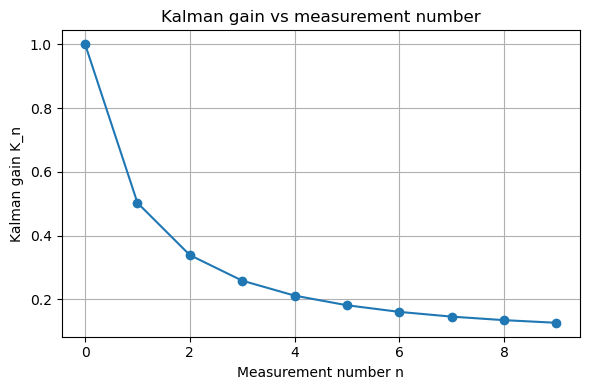

In [8]:
# 1D constant-temperature model matching Becker Example 6

# ------------------------------------------------------------
# Step 1: Define state (names + initial values)
# ------------------------------------------------------------

# Single state: temperature T
initial_states = {"T": 60.0}   # very wrong initial guess on purpose

# Initial covariance: huge uncertainty on T
initial_covariance = {"T": 100.0**2}


# ------------------------------------------------------------
# Step 2: Define system model (linear, Gaussian)
# ------------------------------------------------------------

class ConstantTemperatureSystem:
    """
    1D constant-temperature system.

    State:
        x = [T]

    Dynamics:
        x_{k+1} = x_k + w_k

    Measurement:
        z_k = x_k + v_k
    """

    def __init__(self, q: float, r: float):
        self.q = float(q)
        self.r = float(r)

    # --- Linear system matrices ---

    def F(self, dt: float) -> np.ndarray:
        return np.array([[1.0]])

    def H(self) -> np.ndarray:
        return np.array([[1.0]])

    # --- Noise models ---

    def Q(self, dt: float) -> np.ndarray:
        return np.array([[self.q]])

    def R(self) -> np.ndarray:
        return np.array([[self.r]])


# Kalman filter parameters from Becker Example 6
q = 1.0e-4        # process noise variance
sigma_r = 0.1     # measurement std dev
r = sigma_r**2    # measurement variance

# Instantiate system model
const_temp_system = ConstantTemperatureSystem(q=q, r=r)


# ------------------------------------------------------------
# Step 3: Measurements and filter execution
# ------------------------------------------------------------

# True temperature values at measurement times (for reference only)
true_temps = np.array([
    50.005, 49.994, 49.993, 50.001, 50.006,
    49.998, 50.021, 50.005, 50.000, 49.997
])

# Measured temperatures
measurements = np.array([
    49.986, 49.963, 50.090, 50.001, 50.018,
    50.050, 49.938, 49.858, 49.965, 50.114
])

n_meas = len(measurements)
#indices = np.arange(1, n_meas + 1)  # 1..N

# Create Kalman filter
kf = LinearKF(
    states=initial_states,
    initial_covariance=initial_covariance,
    model=const_temp_system,
)

logger = KalmanLogger()

dt = 5.0  # seconds between measurements (not used by this model)

for k, z in enumerate(measurements):#, start=1):
    kf.predict(dt=dt)
    kf.update(np.array([z]))
    logger.log(kf, n=k, t= k*dt, z=z)

# ------------------------------------------------------------
# Step 4: Analyse results
# ------------------------------------------------------------

arrays = logger.as_arrays()

indices = arrays["n"]
print(indices)

# Extract estimated temperature (posterior x_est) and covariance P_est
x_est_mat = np.stack(arrays["x_est"])     # shape: (N, 1)
P_est_mat = np.stack(arrays["P_est"])     # shape: (N, 1, 1)

estimates = x_est_mat[:, 0]              # (N,)
sigmas = np.sqrt(P_est_mat[:, 0, 0])     # (N,)

ci_upper = estimates + 1.96 * sigmas
ci_lower = estimates - 1.96 * sigmas

# Extract Kalman gains
K_list = arrays["K"].reshape(10,)
print(K_list.shape)

# Example: plot Kalman gain vs measurement number
plt.figure(figsize=(6, 4))
plt.plot(indices, K_list, marker="o")
plt.xlabel("Measurement number n")
plt.ylabel("Kalman gain K_n")
plt.title("Kalman gain vs measurement number")
plt.grid(True)
plt.tight_layout()
plt.show()

# You can similarly plot:
# - estimates vs true_temps
# - confidence intervals vs measurements

In [9]:
ex1_logged_df = logger.to_dataframe()
ex1_logged_df

,n,t,z,z_pred,innovation,S,K,x_pred,x_est,P_pred,P_est,NIS
0,0,0.0,49.986,[60.0],[-10.014000000000003],[[10000.0101]],[[0.9999990000010099]],[60.0],[49.98601001398988],[[10000.0001]],[[0.009999990000010102]],0.010028
1,1,5.0,49.963,[49.98601001398988],[-0.02301001398988234],[[0.0200999900000101]],[[0.5024873146705559]],[49.98601001398988],[49.974447773849576],[[0.010099990000010101]],[[0.005024873146705558]],0.026341
2,2,10.0,50.09,[49.974447773849576],[0.11555222615042737],[[0.015124873146705561]],[[0.3388374300396587]],[49.974447773849576],[50.01360119319375],[[0.005124873146705559]],[[0.0033883743003965882]],0.882805
3,3,15.0,50.001,[50.01360119319375],[-0.012601193193752636],[[0.01348837430039659]],[[0.2586208109819448]],[50.01360119319375],[50.010342262390644],[[0.003488374300396588]],[[0.0025862081098194482]],0.011772
4,4,20.0,50.018,[50.010342262390644],[0.0076577376093567295],[[0.01268620810981945]],[[0.2117423966693605]],[50.010342262390644],[50.011963730105116],[[0.002686208109819448]],[[0.002117423966693605]],0.004622
5,5,25.0,50.05,[50.011963730105116],[0.038036269894881514],[[0.012217423966693607]],[[0.18149685013294212]],[50.011963730105116],[50.01886719328184],[[0.002217423966693605]],[[0.0018149685013294217]],0.118418
6,6,30.0,49.938,[50.01886719328184],[-0.08086719328183989],[[0.011914968501329424]],[[0.16071956053562017]],[50.01886719328184],[50.00587025351584],[[0.0019149685013294217]],[[0.0016071956053562019]],0.548848
7,7,35.0,49.858,[50.00587025351584],[-0.1478702535158405],[[0.011707195605356205]],[[0.1458244709411993]],[50.00587025351584],[49.98430715202895],[[0.001707195605356202]],[[0.0014582447094119932]],1.867707
8,8,40.0,49.965,[49.98430715202895],[-0.01930715202894362],[[0.011558244709411995]],[[0.134816725946553]],[49.98430715202895],[49.98170422500505],[[0.0015582447094119932]],[[0.0013481672594655304]],0.032251
9,9,45.0,50.114,[49.98170422500505],[0.13229577499494383],[[0.011448167259465533]],[[0.1264977377289943]],[49.98170422500505],[49.99843934125302],[[0.0014481672594655304]],[[0.0012649773772899432]],1.528819


### 4.2.2 - Multivariate Linear Kalman Filter Example

[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34]
[0.99655075 0.92315683 0.81778357 0.72466738 0.68708919 0.68382219
 0.68052426 0.66539927 0.64254783 0.61816315 0.59640613 0.57941807
 0.56781426 0.5610581  0.55788111 0.55680961 0.55663268 0.55662531
 0.55650902 0.55627639 0.55601579 0.5558044  0.55567209 0.55560927
 0.55558924 0.55558668 0.55558617 0.55558219 0.55557528 0.55556793
 0.55556215 0.5555586  0.55555695 0.55555643 0.55555637]


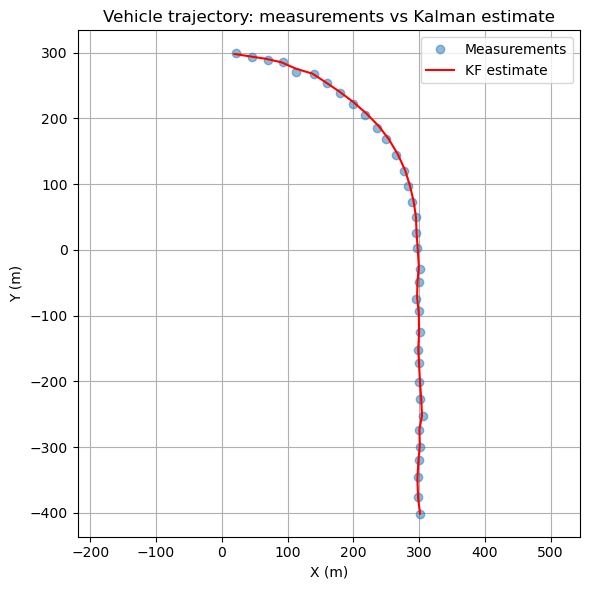

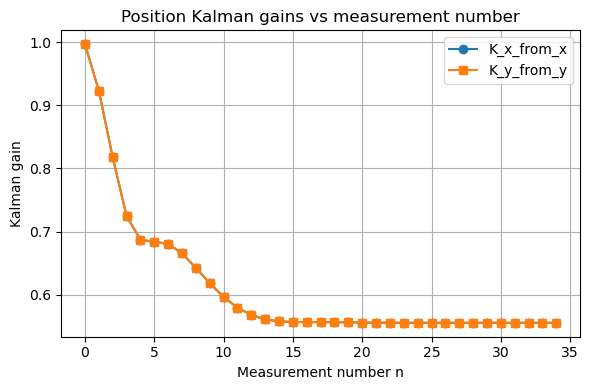

In [10]:
# Multi-Variate constant-acceleration model matching Becker Example 9

# ------------------------------------------------------------
# Step 1: Define state (names + initial values)
# ------------------------------------------------------------

# 6-state constant-acceleration model:
#   x = [x, vx, ax,  y, vy, ay]^T
#
# Use the first measurement as a crude position guess,
# and start with zero velocity/acceleration.

# Measurements (position only)
measurements = np.array([
    [301.50, -401.46],
    [298.23, -375.44],
    [297.83, -346.15],
    [300.42, -320.20],
    [301.94, -300.08],
    [299.50, -274.12],
    [305.98, -253.45],
    [301.25, -226.40],
    [299.73, -200.65],
    [299.20, -171.62],
    [298.62, -152.11],
    [301.84, -125.19],
    [299.60,  -93.40],
    [295.30,  -74.79],
    [299.30,  -49.12],
    [301.95,  -28.73],
    [296.30,    2.99],
    [295.11,   25.65],
    [295.12,   49.86],
    [289.90,   72.87],
    [283.51,   96.34],
    [276.42,  120.40],
    [264.22,  144.69],
    [250.25,  168.06],
    [236.66,  184.99],
    [217.47,  205.11],
    [199.75,  221.82],
    [179.70,  238.30],
    [160.00,  253.02],
    [140.92,  267.19],
    [113.53,  270.71],
    [93.68,   285.86],
    [69.71,   288.48],
    [45.93,   292.90],
    [20.87,   298.77],
], dtype=float)

n_meas = measurements.shape[0]
#indices = np.arange(n_meas)

# Initial state (very rough)
initial_states = {
    "x":  float(measurements[0, 0]),
    "vx": 0.0,
    "ax": 0.0,
    "y":  float(measurements[0, 1]),
    "vy": 0.0,
    "ay": 0.0,
}

# Initial covariance: large position uncertainty, moderate for velocity,
# smaller for acceleration
initial_covariance = {
    "x":  50.0**2,
    "vx": 10.0**2,
    "ax":  1.0**2,
    "y":  50.0**2,
    "vy": 10.0**2,
    "ay":  1.0**2,
}


# ------------------------------------------------------------
# Step 2: Define system model (linear, Gaussian)
# ------------------------------------------------------------

class ConstantAcceleration2DSystem:
    """
    2D constant-acceleration motion model.

    State:
        x = [x, vx, ax, y, vy, ay]^T

    Dynamics:
        Constant acceleration with white acceleration noise.

    Measurement:
        z = [x, y]^T
    """

    def __init__(self, dt: float, sigma_a: float, sigma_m: float):
        self.dt = float(dt)
        self.sigma_a = float(sigma_a)
        self.sigma_m = float(sigma_m)

    # --- Linear system matrices ---

    def F(self, dt: float) -> np.ndarray:
        return np.array([
            [1, dt, 0.5*dt**2, 0,  0,          0],
            [0,  1,        dt, 0,  0,          0],
            [0,  0,         1, 0,  0,          0],
            [0,  0,         0, 1, dt, 0.5*dt**2],
            [0,  0,         0, 0,  1,        dt],
            [0,  0,         0, 0,  0,         1],
        ], dtype=float)

    def H(self) -> np.ndarray:
        return np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0],
        ], dtype=float)

    # --- Noise models ---

    def Q(self, dt: float) -> np.ndarray:
        q3 = np.array([
            [dt**4/4, dt**3/2, dt**2/2],
            [dt**3/2, dt**2,   dt     ],
            [dt**2/2, dt,      1      ],
        ], dtype=float)

        Q = self.sigma_a**2 * np.block([
            [q3,               np.zeros((3, 3))],
            [np.zeros((3, 3)), q3              ],
        ])
        return Q

    def R(self) -> np.ndarray:
        return np.diag([self.sigma_m**2, self.sigma_m**2])


# Model parameters
dt = 1.0                # measurement period (s)
sigma_a = 0.2           # random acceleration std (m/s^2)
sigma_m = 3.0           # measurement std (m)

# Instantiate system model
motion_model = ConstantAcceleration2DSystem(
    dt=dt,
    sigma_a=sigma_a,
    sigma_m=sigma_m,
)


# ------------------------------------------------------------
# Step 3: Run Kalman filter
# ------------------------------------------------------------

kf = LinearKF(
    states=initial_states,
    initial_covariance=initial_covariance,
    model=motion_model,
)

logger = KalmanLogger()

for k, z in enumerate(measurements):#, start=1):
    kf.predict(dt=dt)
    kf.update(z)              # z is shape (2,)
    logger.log(kf, n=k, t=k*dt, z=z)


# ------------------------------------------------------------
# Step 4: Analyse results
# ------------------------------------------------------------
arrays = logger.as_arrays()

indices = arrays["n"]
print(indices)
# x_est: list of (6,) → (N, 6)
x_est_mat = np.stack(arrays["x_est"])
P_est_mat = np.stack(arrays["P_est"])

# Extract position estimates and 1σ bounds
x_est = x_est_mat[:, 0]
y_est = x_est_mat[:, 3]

sigma_x = np.sqrt(P_est_mat[:, 0, 0])
sigma_y = np.sqrt(P_est_mat[:, 3, 3])

# Extract Kalman gain matrices K_k (6x2)
#print(arrays["K"])
K_x_from_x = np.array([K[0, 0] if isinstance(K, np.ndarray) else np.nan for K in arrays["K"]])
K_y_from_y = np.array([K[3, 1] if isinstance(K, np.ndarray) else np.nan for K in arrays["K"]])

print(K_x_from_x)

# Trajectory plot
plt.figure(figsize=(6, 6))
plt.plot(measurements[:, 0], measurements[:, 1], "o", label="Measurements", alpha=0.5)
plt.plot(x_est, y_est, "-r", label="KF estimate")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Vehicle trajectory: measurements vs Kalman estimate")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Kalman gain evolution
plt.figure(figsize=(6, 4))
plt.plot(indices, K_x_from_x, marker="o", label="K_x_from_x")
plt.plot(indices, K_y_from_y, marker="s", label="K_y_from_y")
plt.xlabel("Measurement number n")
plt.ylabel("Kalman gain")
plt.title("Position Kalman gains vs measurement number")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [11]:
ex2_logged_df = logger.to_dataframe()
ex2_logged_df

,n,t,z,z_pred,innovation,S,K,x_pred,x_est,P_pred,P_est,NIS
0,0,0.0,"[301.5, -401.46]","[301.5, -401.46]","[0.0, 0.0]","[[2609.26, 0.0], [0.0, 2609.26]]","[[0.9965507461885746, 0.0], [0.038524332569387...","[301.5, 0.0, 0.0, -401.46, 0.0, 0.0]","[301.5, 0.0, 0.0, -401.46, 0.0, 0.0]","[[2600.26, 100.52, 0.52, 0.0, 0.0, 0.0], [100....","[[8.96895671569717, 0.3467189931244873, 0.0017...",0.000000
1,1,1.0,"[298.23, -375.44]","[301.5, -401.46]","[-3.269999999999982, 26.019999999999982]","[[117.12166384338856, 0.0], [0.0, 117.12166384...","[[0.9231568293630585, 0.0], [0.850277759318151...","[301.5, 0.0, 0.0, -401.46, 0.0, 0.0]","[298.4812771679828, -2.780408272970341, -0.043...","[[108.12166384338856, 99.58594590037023, 1.561...","[[8.308411464267527, 7.652499833863367, 0.1200...",5.871956
2,2,2.0,"[297.83, -346.15]","[295.6790676810783, -355.14175567634817]","[2.1509323189216616, 8.991755676348191]","[[49.39181329787212, 0.0], [0.0, 49.3918132978...","[[0.8177835677802958, 0.0], [0.508012502721476...","[295.6790676810783, -2.824010700838539, -0.043...","[297.43806478690004, -1.7313101903186376, 0.01...","[[40.39181329787212, 25.0916586874039, 1.44152...","[[7.360052110022663, 4.572112524493285, 0.2626...",1.730614
3,3,3.0,"[300.42, -320.2]","[295.71634129769933, -320.4446510438079]","[4.703658702300686, 0.2446510438078917]","[[32.68773608025588, 0.0], [0.0, 32.6877360802...","[[0.7246673805153426, 0.0], [0.385440930211232...","[295.71634129769933, -1.7121367880827871, 0.01...","[299.1249293283338, 0.10084579752814671, 0.299...","[[23.68773608025588, 12.599191401273083, 1.949...","[[6.522006424638083, 3.4689683719010898, 0.536...",0.678672
4,4,4.0,"[301.94, -300.08]","[299.3756545702755, -292.2125895758224]","[2.564345429724483, -7.867410424177592]","[[28.762189873967394, 0.0], [0.0, 28.762189873...","[[0.6870891945489211, 0.0], [0.374396701154237...","[299.3756545702755, 0.40060468635527735, 0.299...","[301.1375886061301, 1.3606871558640696, 0.5254...","[[19.762189873967394, 10.76846900678521, 2.531...","[[6.183802750940291, 3.3695703103881387, 0.792...",2.380626
5,5,5.0,"[299.5, -274.12]","[302.7610001612965, -272.23119744994244]","[-3.261000161296522, -1.8888025500575623]","[[28.4649956220499, 0.0], [0.0, 28.46499562204...","[[0.6838221892074239, 0.0], [0.38291419509553,...","[302.7610001612965, 1.886135954468717, 0.52544...","[300.531055891993, 0.6374527024994658, 0.20832...","[[19.4649956220499, 10.899650887015024, 2.7681...","[[6.154399702866815, 3.4462277558597703, 0.875...",0.498918
6,6,6.0,"[305.98, -253.45]","[301.27267073393085, -249.01932958825134]","[4.707329266069166, -4.43067041174865]","[[28.17115279021754, 0.0], [0.0, 28.1711527902...","[[0.6805242558932392, 0.0], [0.368824793777224...","[301.27267073393085, 0.8457769813763147, 0.208...","[304.47612247996705, 2.5819567271757675, 0.628...","[[19.17115279021754, 10.39021961831866, 2.5146...","[[6.1247183030391525, 3.319423143995018, 0.803...",1.483425
7,7,7.0,"[301.25, -226.4]","[307.37233447280636, -229.615045297771]","[-6.122334472806358, 3.2150452977709847]","[[26.897730008535394, 0.0], [0.0, 26.897730008...","[[0.6653992735764672, 0.0], [0.337121039432398...","[307.37233447280636, 3.2104672585027876, 0.628...","[303.29853756200885, 1.1464994972775, 0.166050...","[[17.897730008535394, 9.06779069884948, 2.0317...","[[5.988593462188204, 3.0340893548915906, 0.679...",1.777826
8,8,8.0,"[299.73, -200.65]","[304.5280621141455, -204.4986217110897]","[-4.798062114145466, 3.8486217110896916]","[[25.17819392166823, 0.0], [0.0, 25.1781939216...","[[0.642547832143963, 0.0], [0.3022849627586629...","[304.5280621141455, 1.31254960699576, 0.166050...","[301.4450777042092, -0.13783242049245392, -0.1...","[[16.17819392166823, 7.610989411941874, 1.5907...","[[5.782930489295667, 2.7205646648279664, 0.568...",1.502621
9,9,9.0,"[299.2, -171.62]","[301.23869690209773, -178.1683636211192]","[-2.0386969020977403, 6.548363621119194]","[[23.57027621795287, 0.0], [0.0, 23.5702762179...","[[0.

# 5 - Extended Kalman Filter

## 5.1 - ExtendedKF

In [12]:
class ExtendedKF(BaseKalmanFilter):
    """
    Discrete-time Extended Kalman Filter (EKF) for nonlinear-Gaussian systems.

    System model
    ------------
        x_{n+1} = f(x_n, u_n, dt) + w_n
        z_n     = h(x_n)          + v_n

    Noise assumptions
    -----------------
        w_n ~ N(0, Q(dt))   process noise
        v_n ~ N(0, R())     measurement noise

    Linearization (EKF core idea)
    -----------------------------
    The EKF propagates the state mean and covariance by locally linearizing
    the nonlinear system about the current estimate.

        F_n = df/dx |_{(x_n, u_n, dt)}
        H_n = dh/dx |_{(x_{n|n-1})}

    Estimation semantics
    --------------------
    - predict(u, dt):
        Computes the a priori (prior) estimate:

            x_{n+1|n} = f(x_{n|n}, u_n, dt)
            P_{n+1|n} = F_n P_{n|n} F_n^T + Q(dt)

    - update(z):
        Computes the a posteriori (posterior) estimate:

            innovation        y_n = z_n - h(x_{n|n-1})
            innovation_cov    S_n = H_n P_{n|n-1} H_n^T + R
            kalman_gain       K_n = P_{n|n-1} H_n^T S_n^{-1}

            x_{n|n} = x_{n|n-1} + K_n y_n
            P_{n|n} = (I - K_n H_n) P_{n|n-1} (I - K_n H_n)^T + K_n R K_n^T

    Model contract
    --------------
    Required methods on `model`:
      - f(x, u, dt) -> x_next
      - h(x)        -> z_pred
      - F_jacobian(x, u, dt) -> F_n
      - H_jacobian(x)        -> H_n
      - Q(dt) -> Q
      - R()   -> R

    Numerical stability notes
    -------------------------
    - Kalman gain is computed via linear solve (no explicit matrix inverse).
    - Joseph form covariance update is used to preserve symmetry and
      positive semi-definiteness.
    - Covariance matrices are explicitly symmetrized to reduce
      floating-point drift.
    """

    def __init__(self, states, initial_covariance, model: "SystemModel") -> None:
        
        super().__init__(states=states, initial_covariance=initial_covariance, model=model)


    # ------------------------------------------------------------------
    # Prediction implementation (time update)
    # ------------------------------------------------------------------
    def _predict_impl(self, u, dt) -> None:
        """
        Time update (prediction).

        Computes the a priori estimate:

            x_{n+1|n} = f(x_{n|n}, u_n, dt)
            P_{n+1|n} = F_n P_{n|n} F_n^T + Q
        """
        self._last_z_pred = None
        self._last_innovation = None
        self._last_S = None
        self._last_gain = None

        if dt is None:
            raise ValueError("ExtendedKF.predict() requires a time step dt.")

        # Current posterior state
        x_n = np.asarray(self.x, dtype=float)

        # --- Nonlinear state propagation ---
        x_pred = np.asarray(self.model.f(x_n, u, dt), dtype=float)

        # --- Linearization of dynamics ---
        F_n = np.asarray(self.model.F_jacobian(x_n, u, dt), dtype=float)

        # --- Process noise ---
        Q = np.asarray(self.model.Q(dt), dtype=float)

        # --- Covariance prediction ---
        P_pred = F_n @ self.P @ F_n.T + Q
        P_pred = self._symmetrize(P_pred)

        # Store diagnostics (a priori)
        self._last_x_pred = x_pred.copy()
        self._last_P_pred = P_pred.copy()

        # Commit
        self.x = x_pred
        self.P = P_pred

    # ------------------------------------------------------------------
    # Update implementation (measurement correction)
    # ------------------------------------------------------------------
    def _update_impl(self, z) -> None:
        """
        Measurement update (correction).

        Computes the a posteriori estimate:

            y_n = z_n - h(x_{n|n-1})
            S_n = H_n P_{n|n-1} H_n^T + R
            K_n = P_{n|n-1} H_n^T S_n^{-1}

            x_{n|n} = x_{n|n-1} + K_n y_n
            P_{n|n} = (I - K_n H_n) P_{n|n-1} (I - K_n H_n)^T + K_n R K_n^T
        """
        # Current prior state
        x_prior = np.asarray(self.x, dtype=float)

        # Measurement
        z = np.atleast_1d(np.asarray(z, dtype=float))
        
        # --- Predicted measurement ---
        z_pred = np.atleast_1d(np.asarray(self.model.h(x_prior), dtype=float))

        if z.shape != (self.m,):
            raise ValueError(f"Measurement dimension mismatch: expected ({z_hat.shape[0]},), got {z.shape}.")

        # --- Linearization of measurement model ---
        H_n = np.asarray(self.model.H_jacobian(x_prior), dtype=float)

        # --- Measurement noise ---
        R = np.asarray(self.model.R(), dtype=float)

        # --- Innovation ---
        y_n = z - z_pred

        # --- Innovation covariance ---
        S_n = H_n @ self.P @ H_n.T + R
        S_n = self._symmetrize(S_n)

        # --- Kalman gain (solve-based, no explicit inverse) ---
        try:
            K_n = np.linalg.solve(S_n, (self.P @ H_n.T).T).T
        except np.linalg.LinAlgError as e:
            raise np.linalg.LinAlgError(
                "Innovation covariance S_n is singular or ill-conditioned."
            ) from e

        # --- State update ---
        x_post = self.x + K_n @ y_n

        # --- Covariance update (Joseph form) ---
        I = np.eye(self.n)
        I_minus_KH = I - K_n @ H_n

        P_post = (I_minus_KH @ self.P @ I_minus_KH.T) + (K_n @ R @ K_n.T)
        P_post = self._symmetrize(P_post)

        # Commit
        self.x = x_post
        self.P = P_post

        # Diagnostics
        self._last_z_pred = z_pred
        self._last_innovation = y_n
        self._last_S = S_n
        self._last_gain = K_n



## 5.2 - Examples

### 5.2.1 - Vehicle Location Estimation using Radar

In [13]:
# ============================================================
# EKF Example: Vehicle Tracking with Radar (Range + Bearing)
# ============================================================

# ------------------------------------------------------------
# Step 1: Define state, initial uncertainty, and noise levels
# ------------------------------------------------------------

# State vector:
#   x = [x, vx, ax, y, vy, ay]^T
initial_states = {
    "x":  400.0,
    "vx": 0.0,
    "ax": 0.0,
    "y":  -300.0,
    "vy": 0.0,
    "ay": 0.0,
}

# Large initial uncertainty on all states
initial_covariance = {name: 500.0 for name in initial_states.keys()}

# Sampling period
dt = 1.0

# Noise parameters
sigma_a   = 0.2      # acceleration process noise (m/s^2)
sigma_r   = 5.0      # radar range std (m)
sigma_phi = 0.0087   # radar bearing std (rad)


# ------------------------------------------------------------
# Step 2: Define the system physics (nonlinear model)
# ------------------------------------------------------------
class VehicleRadarSystem:
    """
    Vehicle motion model with radar measurements (range, bearing).

    State:
        x = [x, vx, ax, y, vy, ay]^T

    Measurement:
        z = [range, bearing]^T
    """

    def __init__(self, dt: float, sigma_a: float, sigma_r: float, sigma_phi: float):
        self.dt = float(dt)
        self.sigma_a = float(sigma_a)
        self.sigma_r = float(sigma_r)
        self.sigma_phi = float(sigma_phi)

    # Nonlinear dynamics
    def f(self, x: np.ndarray, u, dt: float) -> np.ndarray:
        return self.F(dt) @ x

    # Nonlinear measurement
    def h(self, x: np.ndarray) -> np.ndarray:
        px, _, _, py, _, _ = x
        r = np.sqrt(px**2 + py**2)
        phi = np.arctan2(py, px)
        return np.array([r, phi], dtype=float)

    # Jacobians (EKF-specific)
    def F_jacobian(self, x: np.ndarray, u, dt: float) -> np.ndarray:
        return self.F(dt)

    def H_jacobian(self, x: np.ndarray) -> np.ndarray:
        px, _, _, py, _, _ = x
        r2 = max(px**2 + py**2, 1e-12)
        r = np.sqrt(r2)

        return np.array([
            [ px/r,   0.0, 0.0,  py/r,   0.0, 0.0],
            [-py/r2,  0.0, 0.0,  px/r2,  0.0, 0.0],
        ])

    # Linear dynamics helper
    def F(self, dt: float) -> np.ndarray:
        return np.array([
            [1, dt, 0.5*dt**2, 0,  0,           0],
            [0,  1, dt,        0,  0,           0],
            [0,  0, 1,         0,  0,           0],
            [0,  0, 0,         1, dt, 0.5*dt**2],
            [0,  0, 0,         0,  1, dt],
            [0,  0, 0,         0,  0, 1],
        ], dtype=float)

    # Noise models
    def Q(self, dt: float) -> np.ndarray:
        q3 = np.array([
            [dt**4/4, dt**3/2, dt**2/2],
            [dt**3/2, dt**2,   dt],
            [dt**2/2, dt,      1],
        ]) * self.sigma_a**2

        Q = np.zeros((6, 6))
        Q[0:3, 0:3] = q3
        Q[3:6, 3:6] = q3
        return Q

    # Measurement noise covariance
    def R(self) -> np.ndarray:
        return np.diag([self.sigma_r**2, self.sigma_phi**2])

    # -------------------------------
    # Angle utility
    # -------------------------------
    @staticmethod
    def wrap_angle(rad: float) -> float:
        return (rad + np.pi) % (2.0 * np.pi) - np.pi


# ------------------------------------------------------------
# Step 3: Measurements and filter execution
# ------------------------------------------------------------

# Radar measurements: [range, bearing]
measurements = np.array([
    [502.55, -0.9316],
    [477.34, -0.8977],
    [457.21, -0.8512],
    [442.94, -0.8114],
    [427.27, -0.7853],
    [406.05, -0.7392],
    [400.73, -0.7052],
    [377.32, -0.6478],
    [360.27, -0.5900],
    [345.93, -0.5183],
    [333.34, -0.4698],
    [328.07, -0.3952],
    [315.48, -0.3026],
    [301.41, -0.2445],
    [302.87, -0.1626],
    [304.25, -0.0937],
    [294.46,  0.0085],
    [294.29,  0.0856],
    [299.38,  0.1675],
    [299.37,  0.2467],
    [300.68,  0.3290],
    [304.10,  0.4149],
    [301.96,  0.5040],
    [300.30,  0.5934],
    [301.90,  0.6670],
    [296.70,  0.7537],
    [297.07,  0.8354],
    [295.29,  0.9195],
    [296.31,  1.0039],
    [300.62,  1.0923],
    [292.30,  1.1546],
    [298.11,  1.2564],
    [298.07,  1.3274],
    [298.92,  1.4090],
    [298.04,  1.5011],
], dtype=float)

# Instantiate system + filter
system = VehicleRadarSystem(dt, sigma_a, sigma_r, sigma_phi)

ekf = ExtendedKF(
    states=initial_states,
    initial_covariance=initial_covariance,
    model=system,
)

logger = KalmanLogger()

for k, z in enumerate(measurements):#, start=1):
    ekf.predict(u=None, dt=dt)

    # Bearing innovation wrapping (critical for correctness)
    z_hat = system.h(ekf.state)
    z_wrapped = z.copy()
    z_wrapped[1] = z_hat[1] + system.wrap_angle(z[1] - z_hat[1])

    ekf.update(z_wrapped)
    logger.log(ekf, n=k, z=z)


# ------------------------------------------------------------
# Step 4: Analysis
# ------------------------------------------------------------
ex3_logged_df = logger.to_dataframe()
ex3_logged_df.head()

,n,t,z,z_pred,innovation,S,K,x_pred,x_est,P_pred,P_est,NIS
0,0,None,"[502.55, -0.9316]","[500.0, -0.6435011087932844]","[2.5500000000000114, -0.2880988912067157]","[[1150.01, 0.0], [0.0, 0.00457573]]","[[0.7826088468795923, 295.0375131399798], [0.5...","[400.0, 0.0, 0.0, -300.0, 0.0, 0.0]","[316.995672159528, -55.33720230656691, -18.446...","[[1125.01, 750.02, 250.02, 0.0, 0.0, 0.0], [75...","[[22.35159374846137, 14.90132740439729, 4.9673...",18.145049
1,1,None,"[477.34, -0.8977]","[563.8131215633497, -1.1065731371755223]","[-86.47312156334971, 0.20887313717552214]","[[1043.1127650380076, 0.013099349214172162], [...","[[0.437144955210652, 492.42273550801605], [0.5...","[252.4351109287405, -73.7839201550081, -18.446...","[317.4877036581164, 7.635162814827908, 18.2067...","[[1015.147470609387, 1257.6338857763903, 564.4...","[[23.683267382685102, 29.339430597477758, 13.1...",20.760255
2,2,None,"[457.21, -0.8512]","[447.9909493233547, -0.7286772782964349]","[9.219050676645281, -0.12252272170356493]","[[370.80360722227016, -0.0015353771895426083],...","[[0.6957008817096402, 285.0219190560681], [0.7...","[334.2262609417981, 25.841951752535415, 18.206...","[305.71830135814344, -5.280955358801226, 2.627...","[[336.785186274873, 368.194386329862, 182.0316...","[[19.411320600214633, 21.225324440491868, 10.4...",9.028086
3,3,None,"[442.94, -0.8114]","[411.34786922628473, -0.7472405028281492]","[31.59213077371527, -0.06415949717185088]","[[247.95202308555196, 0.0017170256444043186], ...","[[0.6597373912235758, 260.36271889355487], [0....","[301.7512474266142, -2.6531525042572284, 2.627...","[305.88901623995275, 0.07249678887364075, 3.44...","[[200.39500727802698, 196.80169893826601, 84.5...","[[17.60826962192276, 17.18123721089324, 7.3529...",7.807898
4,4,None,"[427.27, -0.7853]","[413.99327987731385, -0.7329449180904549]","[13.276720122686129, -0.0523550819095453]","[[170.2792419332901, -0.0021774898254182037], ...","[[0.6336532507617858, 242.7283249207733], [0.5...","[307.68282670230775, 3.515124135836313, 3.4426...","[303.3876022345084, -0.7375834875671945, 1.810...","[[121.02794620235149, 100.30443964888227, 35.4...","[[16.862224984623985, 13.934615458286395, 4.92...",5.435397


In [14]:
ex3_logged_df.loc[0,"P_pred"]

array([[1125.01,  750.02,  250.02,    0.  ,    0.  ,    0.  ],
       [ 750.02, 1000.04,  500.04,    0.  ,    0.  ,    0.  ],
       [ 250.02,  500.04,  500.04,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , 1125.01,  750.02,  250.02],
       [   0.  ,    0.  ,    0.  ,  750.02, 1000.04,  500.04],
       [   0.  ,    0.  ,    0.  ,  250.02,  500.04,  500.04]])

In [15]:
# One-step-ahead prediction after final update
ekf.predict(u=None, dt=dt)

x_36_35 = ekf.state
P_36_35 = ekf.covariance

print("x_36|35 =", np.round(x_36_35, 2))
print("P_36|35 =\n", np.round(P_36_35, 2))

x_36|35 = [ -5.61 -26.82  -0.85 299.99   0.74  -1.8 ]
P_36|35 =
 [[9.490e+00 3.990e+00 8.200e-01 1.680e+00 6.100e-01 9.000e-02]
 [3.990e+00 2.240e+00 5.700e-01 4.100e-01 2.700e-01 5.000e-02]
 [8.200e-01 5.700e-01 2.000e-01 2.000e-02 4.000e-02 1.000e-02]
 [1.680e+00 4.100e-01 2.000e-02 2.373e+01 8.000e+00 1.380e+00]
 [6.100e-01 2.700e-01 4.000e-02 8.000e+00 3.630e+00 7.900e-01]
 [9.000e-02 5.000e-02 1.000e-02 1.380e+00 7.900e-01 2.300e-01]]


### 5.2.2 - Pendulum Angle Estimation

In [18]:
# ============================================================
# EKF Example: Estimating Pendulum angle
# ============================================================

# ------------------------------------------------------------
# Step 1: Define state, initial uncertainty, and noise levels
# ------------------------------------------------------------
x0 = {
    "theta": 0.0873,     # rad (intentionally imperfect)
    "omega": 0.0,        # rad/s
}

P0 = {
    "theta": 5,
    "omega": 5,
}

# ------------------------------------------------------------
# Step 2: Define the system physics (model)
# ------------------------------------------------------------
class PendulumSystem:
    """
    Pendulum system with exact nonlinear dynamics and linear approximations.

    State vector:
        x = [theta, omega]

    where:
        theta : pendulum angle (rad)
        omega : angular velocity (rad/s)

    Notes
    -----
    - f(), h() define the exact nonlinear system
    - F(), H() define small-angle linear approximations (theta ≈ 0)
    - Jacobians are provided explicitly for EKF
    """

    def __init__(self, L, g, sigma_a, sigma_xm):
        self.L = float(L)
        self.g = float(g)
        self.sigma_a = float(sigma_a)
        self.sigma_xm = float(sigma_xm)

    # ------------------------------------------------------------------
    # Nonlinear dynamics
    # ------------------------------------------------------------------
    def f(self, x, u, dt):
        """
        Discrete-time nonlinear state transition.

            theta_{n+1} = theta_n + dt * omega_n
            omega_{n+1} = omega_n - dt * (g/L) * sin(theta_n)
        """
        theta, omega = x

        theta_next = theta + dt * omega
        omega_next = omega - dt * (self.g / self.L) * np.sin(theta)

        x_next = np.array(
            [theta_next, omega_next],
            dtype=float
        )

        return x_next

    def F_jacobian(self, x, u, dt):
        """
        Jacobian of the nonlinear dynamics ∂f/∂x evaluated at x.
        """
        theta, _ = x

        dtheta_dtheta = 1.0
        dtheta_domega = dt

        domega_dtheta = -dt * (self.g / self.L) * np.cos(theta)
        domega_domega = 1.0

        F = np.array(
            [
                [dtheta_dtheta, dtheta_domega],
                [domega_dtheta, domega_domega],
            ],
            dtype=float
        )

        return F

    # ------------------------------------------------------------------
    # Linear dynamics (small-angle approximation)
    # ------------------------------------------------------------------
    def F(self, dt):
        """
        Linearized state transition matrix assuming sin(theta) ≈ theta.

        Valid for small angles only.
        """
        a21 = -dt * (self.g / self.L)

        F = np.array(
            [
                [1.0, dt],
                [a21, 1.0],
            ],
            dtype=float
        )

        return F

    # ------------------------------------------------------------------
    # Measurement model
    # ------------------------------------------------------------------
    def h(self, x):
        """
        Nonlinear measurement model.

            z = L * sin(theta)
        """
        theta, _ = x

        z_pred = self.L * np.sin(theta)

        z = np.array([z_pred], dtype=float)
        return z

    def H_jacobian(self, x):
        """
        Jacobian of the nonlinear measurement model ∂h/∂x.
        """
        theta, _ = x

        dz_dtheta = self.L * np.cos(theta)
        dz_domega = 0.0

        H = np.array(
            [[dz_dtheta, dz_domega]],
            dtype=float
        )

        return H

    # ------------------------------------------------------------------
    # Linear measurement (small-angle approximation)
    # ------------------------------------------------------------------
    def H(self):
        """
        Linear measurement matrix assuming sin(theta) ≈ theta.
        """
        H = np.array(
            [[self.L, 0.0]],
            dtype=float
        )

        return H

    # ------------------------------------------------------------------
    # Noise models
    # ------------------------------------------------------------------
    def Q(self, dt):
        """
        Discrete-time process noise covariance.

        Assumes white angular-acceleration noise with std dev sigma_a.
        """
        q11 = dt**4 / 4.0
        q12 = dt**3 / 2.0
        q22 = dt**2

        Q_base = np.array([
            [q11, q12],
            [q12, q22],
        ], dtype=float)

        Q = (self.sigma_a ** 2) * Q_base
        return Q

    def R(self):
        """
        Measurement noise covariance.
        """
        R = np.array([[self.sigma_xm ** 2]], dtype=float)

        return R



# ------------------------------------------------------------
# Step 3: Measurements and filter execution
# -----------------------------------------------------------

z_list = np.array([0.119, 0.113, 0.120, 0.101, 0.099, 0.063, 0.008, -0.017, -0.037, -0.050])

dt = 0.05

system = PendulumSystem(L=0.5, g=9.8, sigma_a=1.0, sigma_xm=0.01)

ekf = ExtendedKF(states=x0, initial_covariance=P0, model=system)

logger = KalmanLogger()

#ekf.predict(dt=dt)

#logger.log(ekf, n=0, t=0.0, z=None)

for n, z in enumerate(z_list):
    ekf.predict(u=None, dt=dt)
    ekf.update(z)
    logger.log(ekf, n=n, t=n * dt, z=z)
    

# ------------------------------------------------------------
# Step 4: Analysis
# ------------------------------------------------------------
ex4_logged_df = logger.to_dataframe()
ex4_logged_df

,n,t,z,z_pred,innovation,S,K,x_pred,x_est,P_pred,P_est,NIS
0,0,0.00,0.119,[0.0435945762394938],[0.07540542376050619],[[1.2436991961795147]],"[[2.0074841416007527], [-1.8548055115855047]]","[0.0873, -0.08544536942940786]","[0.23867519238990076, -0.22530776502383532]","[[5.0125015625, -4.631277195316932], [-4.63127...","[[0.00040303166375742347, -0.00037237920628586...",0.004572
1,1,0.05,0.113,[0.11272738746268887],[0.00027261253731113155],[[0.003443591398399108]],"[[1.9932397799089185], [38.729863504572286]]","[0.22740980413870898, -0.4569950356433199]","[0.22795318629257943, -0.4464367892836246]","[[0.01409058815388487, 0.2737887139318689], [0...","[[0.00040918292920685785, 0.007950673650165073...",0.000022
2,2,0.10,0.12,[0.1020926231701427],[0.017907376829857297],[[0.0005850222629677763]],"[[1.6938175629512107], [19.759168338482795]]","[0.2056313468283982, -0.667901240263893]","[0.23596317620919607, -0.3140663669820963]","[[0.002024493453130807, 0.02361665613554639], ...","[[0.00034605408738817834, 0.004036881607845277...",0.548140
3,3,0.15,0.101,[0.10924160516638419],[-0.008241605166384183],[[0.00033049559576146077]],"[[1.4293810486861518], [11.68545859778703]]","[0.22025985786009125, -0.5431703554203846]","[0.2084794636245078, -0.6394772913714747]","[[0.0009681992922175474, 0.007915211100646843]...","[[0.000292953765385835, 0.002394952066580561],...",0.205522
4,4,0.20,0.099,[0.08779527152209075],[0.011204728477909251],[[0.0002516471663191544]],"[[1.2242573678960997], [7.627090535128697]]","[0.17650559905593408, -0.8423103686685312]","[0.19022307045028972, -0.7568508901459825]","[[0.0006258860069307845, 0.0038992530204126274...","[[0.0002487156982872589, 0.0015494921232164227...",0.498897
5,5,0.25,0.063,[0.07589575101381286],[-0.012895751013812864],[[0.0002113603393052515]],"[[1.0661021007725209], [5.407072070894021]]","[0.1523805259429906, -0.942147277620676]","[0.13863233869612532, -1.0118755327606668]","[[0.0004559466694499684, 0.002312476919812498]...","[[0.0002157200688401052, 0.0010940921685750919...",0.786810
6,6,0.30,0.008,[0.04396243903983257],[-0.03596243903983257],[[0.00018963484114514986]],"[[0.9490169245658108], [4.167988887745111]]","[0.08803856205809198, -1.147300463129934]","[0.05390959876062462, -1.297191509424167]","[[0.0003613327500906398, 0.001586937859770203]...","[[0.00019054133085916913, 0.000836838763482040...",6.819934
7,7,0.35,-0.017,[-0.005474878945614652],[-0.01152512105438535],[[0.00017590119958792627]],"[[0.863049829626231], [3.493240149826012]]","[-0.010949976710583731, -1.3499973297606727]","[-0.020896730472992696, -1.3902573453594567]","[[0.0003036412040812343, 0.0012290039448793416...","[[0.00017262031458145665, 0.000698689916702364...",0.755131
8,8,0.40,-0.037,[-0.0451432408183393],[0.008143240818339302],[[0.0001667391759662052]],"[[0.8038047106583821], [3.165064738927707]]","[-0.09040959774096552, -1.3697800398874294]","[-0.08386402241115877, -1.3440061555127067]","[[0.00026915072604877314, 0.001059809007309752...","[[0.00016142020883162144, 0.000635608879058245...",0.397701
9,9,0.45,-0.05,[-0.075245213269665],[0.025245213269665],[[0.0001612575634795665]],"[[0.7685001870609859], [3.043028367890728]]","[-0.1510643301867941, -1.261915718623293]","[-0.13166337906666206, -1.1850938184902509]","[[0.00025070813339622054, 0.000992728401151435...","[[0.00015547061978769672, 0.000615616644410745...",3.952192


In [17]:
ex4_logged_df["P_est"][0]

array([[5., 0.],
       [0., 5.]])

# 6 - Unscented Kalman Filter

## 6.1 - UnscentedKF

## 6.2 - Examples

### 6.2.1 - Vehicle Location estimation using radar (UnscentedKF implementation)